# A first look at a single-compartment neuron with Hodgkin & Huxley conductances

Stay alert! There's some **potential** for **action** here! 

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [81]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s

In [4]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [5]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [6]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [7]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [8]:
soma.L = 10 * um
soma.diam =  10 * um

In [9]:
volume = soma(0.5).volume() * um**3

In [10]:
area = soma(0.5).area() * um**2

In [11]:
area

array(314.15926536) * um**2

In [12]:
volume

array(785.3981634) * um**3

### Assign the membrane capacitance "everywhere"

In [13]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [14]:
specific_membrane_capacitance = 1 * uF/cm**2

In [15]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100

### Add the Hodgkin-Huxley conductances

In [16]:
# This model includes the transient Na+, persistent K+ and the leak conductances
soma.insert("hh")

__nrnsec_0x36138a0

That's almost too easy!

### Parametize the leak conductance G = 1/R

In [17]:
G = 0.1 * nS  # R = 1/G in our RC circuit

In [18]:
v_rest = -70*mV

In [19]:
tau_m = soma(0.5).cm / soma(0.5).hh.gl

In [20]:
tau_m = (specific_membrane_capacitance * area / G).rescale(ms)

In [21]:
tau_m

array(31.41592654) * ms

In [22]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.hh.gl = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.hh.el = -54.3

### Inspect our parameters

In [23]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [3.1830988618379074e-05],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'minf': [0.0],
   'hinf': [0.0],
   'ninf': [0.0],
   'mtau': [0.0],
   'htau': [0.0],
   'ntau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 10.0,
  'diam': [10.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x36138a0',
 'hoc_internal_name': '__nrnsec_0x36138a0',
 'cell': None}

In [24]:
soma.nseg

1

### Add a current injection

In [25]:
stim = h.IClamp(soma(0.5))

In [53]:
stim.delay = 200 * ms  # Inject current 500ms after the start of the simulation 
stim.dur = 600 * ms  # stop injecting current at 520ms 
stim.amp = 0.015 * nA  # Inject 0.1 nA of current

## Step 3: Run the simulation

### Define recordings of simulation variables

In [27]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

### Set the initial voltage

In [54]:
h.finitialize( float(v_rest) )

1.0

### Run the simulation for 1500ms

In [55]:
h.continuerun( float(1000 * ms) )

0.0

## Step 4: Plot the results

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

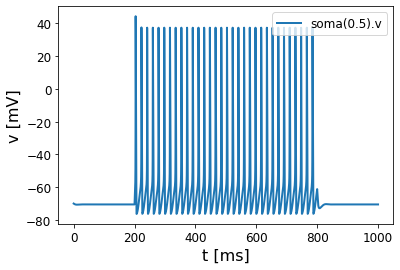

In [56]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
#plt.axis([100,200,-80,30])

In [104]:
def find_spikes(v, t):
    """ Returns times of spikes for a voltage trace and time grid"""
    
    # look for upward crossing of 0mV
    v_arr = np.array(soma_v)
    t_arr = np.array(t) 
    # This is tricky & powerful notation! Let's discuss in class!
    return t_arr[1:][(v_arr[1:]>0) & (v_arr[:-1]<0)] 

In [70]:
spike_times = find_spikes(soma_v, t)

In [74]:
spike_times, len(spike_times)

(array([203.375, 222.425, 241.175, 259.9  , 278.65 , 297.375, 316.1  ,
        334.85 , 353.575, 372.3  , 391.05 , 409.775, 428.5  , 447.25 ,
        465.975, 484.7  , 503.45 , 522.175, 540.925, 559.65 , 578.375,
        597.125, 615.85 , 634.575, 653.325, 672.05 , 690.775, 709.525,
        728.25 , 747.   , 765.725, 784.45 ]),
 32)

In [85]:
firing_freq = (len(spike_times)/(stim.dur*ms)).rescale(Hz)

In [86]:
firing_freq

array(53.33333333) * Hz

(200.0, 400.0, -80.0, 30.0)

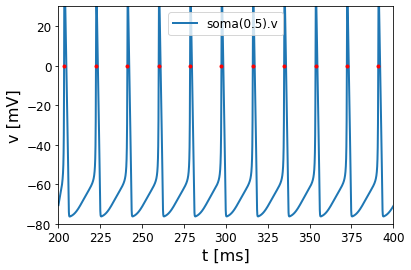

In [76]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot(spike_times, len(spike_times)*[0], 'r.')
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.axis([200,400,-80,30])

## Now it's your turn!

### **Question 1** 
Create a function to return the firing frequency for a given current input I, and plot the firing frequency for a range of currents from 0 to 0.1 nA (e.g. steps of 0.001 nA)



In [99]:
I_range = np.arange(0,0.1,0.001)

In [103]:
def find_freq(I):
    # TODO fixme
    return I*2

In [101]:
# Note this cool notation: List comprehension
freqs = [find_freq(x) for x in I_range]

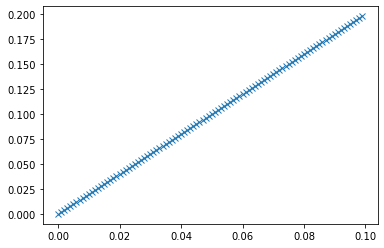

In [102]:
plt.plot(I_range, freqs, 'x')